# Emotion recognition with RMN
This notebook is for generating saliency maps with the GradCAM method, applied to the RNM (Residual Masking Network) model.

In [1]:
from rmn import *
from img_functions import *
import torch
from torchsummary import summary
from pytorch_grad_cam import GradCAM, GradCAMElementWise, GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image

c:\Users\terai\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load database

In [2]:
my_path = ".\\datasets\\BV" # path for Bubble View images
imgs = load_ims(my_path)
imgs = resize_ims(imgs,(224,224))
print(imgs.shape)

(162,)


## Build facial expression analysis model

The model used here is called RMN (Residual Masking Network). The implementation using PyTorch was provided by the authors on Github : https://github.com/phamquiluan/ResidualMaskingNetwork.

In the case of emotion recognition tasks, the model used was designed with a ResNet18 architecture, with added masking blocks and modified final layer. It was pre-trained on ImageNet. The emotions predicted are the following : angry, disgust, fear, happy, sad, surprise, neutral.

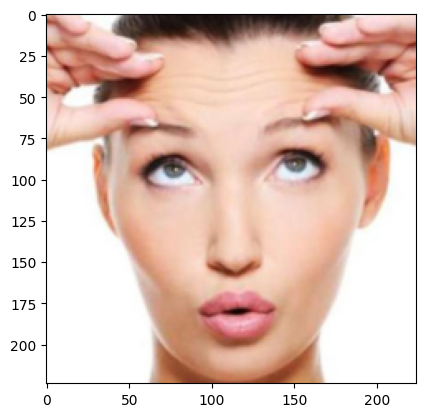

Emotion detected:  surprise 0.9978965520858765
Outputs:  [{'angry': 0.00016565083933528513}, {'disgust': 1.1169468962179963e-05}, {'fear': 6.923019827809185e-05}, {'happy': 9.43916256801458e-06}, {'sad': 0.000650342961307615}, {'surprise': 0.9978965520858765}, {'neutral': 0.0011975968955084682}]


In [3]:
# Display a single image
im_test = np.array(imgs[0])
plt.imshow(im_test)
plt.show()

# Display predictions for a single image
# Please note that the detect_emotion_for_single_face_image function resizes the input image
predict = RMN()
emo_label, emo_proba, emo_list = predict.detect_emotion_for_single_face_image(face_image=im_test)
print("Emotion detected: ", emo_label, emo_proba)
print("Outputs: ",emo_list)

In [4]:
# Build the emotion recognition model
# This is the model of interest in everything that follows
model = get_emo_model()
# Print model architecture
# summary(model,input_size=(3,224,224))

## Apply GradCAM method to generate saliency maps

Here we re-use an existing implementation of GradCAM using PyTorch. Codes can be found on Github : https://github.com/jacobgil/pytorch-grad-cam.

Several CAM methods were implemented by contributors, including GradCAM and GradCAMPlusPlus. Given a deep classification model and an input image, a saliency map can be computed for any selected convolution layer and any selected class.

In [5]:
def compute_gradcam(explainer, model, input_img, target_layer, targets) :

    """
    Parameters :
        explainer : choose 0 to use GradCAM, 1 to use GradCAMPlusPlus
        model : pre-trained neural network
        input_img : should be PIL image
        target_layer :  convolution layer to compute saliency map for
        targets : target class to compute saliency map for. If target=None, the class with the most important score is selected by default.
    
    Outputs :
        grayscale_cam : gradients (1 channel) display
        visualization : gradients (3 channels) display over original image
    """

    # set transformation parameters
    # mean = [0., 0., 0.]
    # std = [255, 255, 255]
    # normalize_torch = transforms.Normalize(mean,std) # cannot be used with PIL image
    to_tensor = transforms.ToTensor()

    # procede to transformation
    normalize_np = np.array(input_img) / np.max(np.array(input_img))
    input_tensor = to_tensor(input_img.copy()).unsqueeze(0)

    if explainer==0 :
        with GradCAM(model=model, target_layers=target_layer, use_cuda=True) as cam :
            # computing saliency map
            grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
            grayscale_cam = grayscale_cam[0, :]
            # overlay heatmap on original input image
            visualization = show_cam_on_image(img=normalize_np, mask=grayscale_cam, use_rgb=True)
    elif explainer==1 :
        with GradCAMPlusPlus(model=model, target_layers=target_layer, use_cuda=True) as cam :
            # computing saliency map
            grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
            grayscale_cam = grayscale_cam[0, :]
            # overlay heatmap on original input image
            visualization = show_cam_on_image(img=normalize_np, mask=grayscale_cam, use_rgb=True)
    else :
        print("Invalid explainer")

    return grayscale_cam, visualization

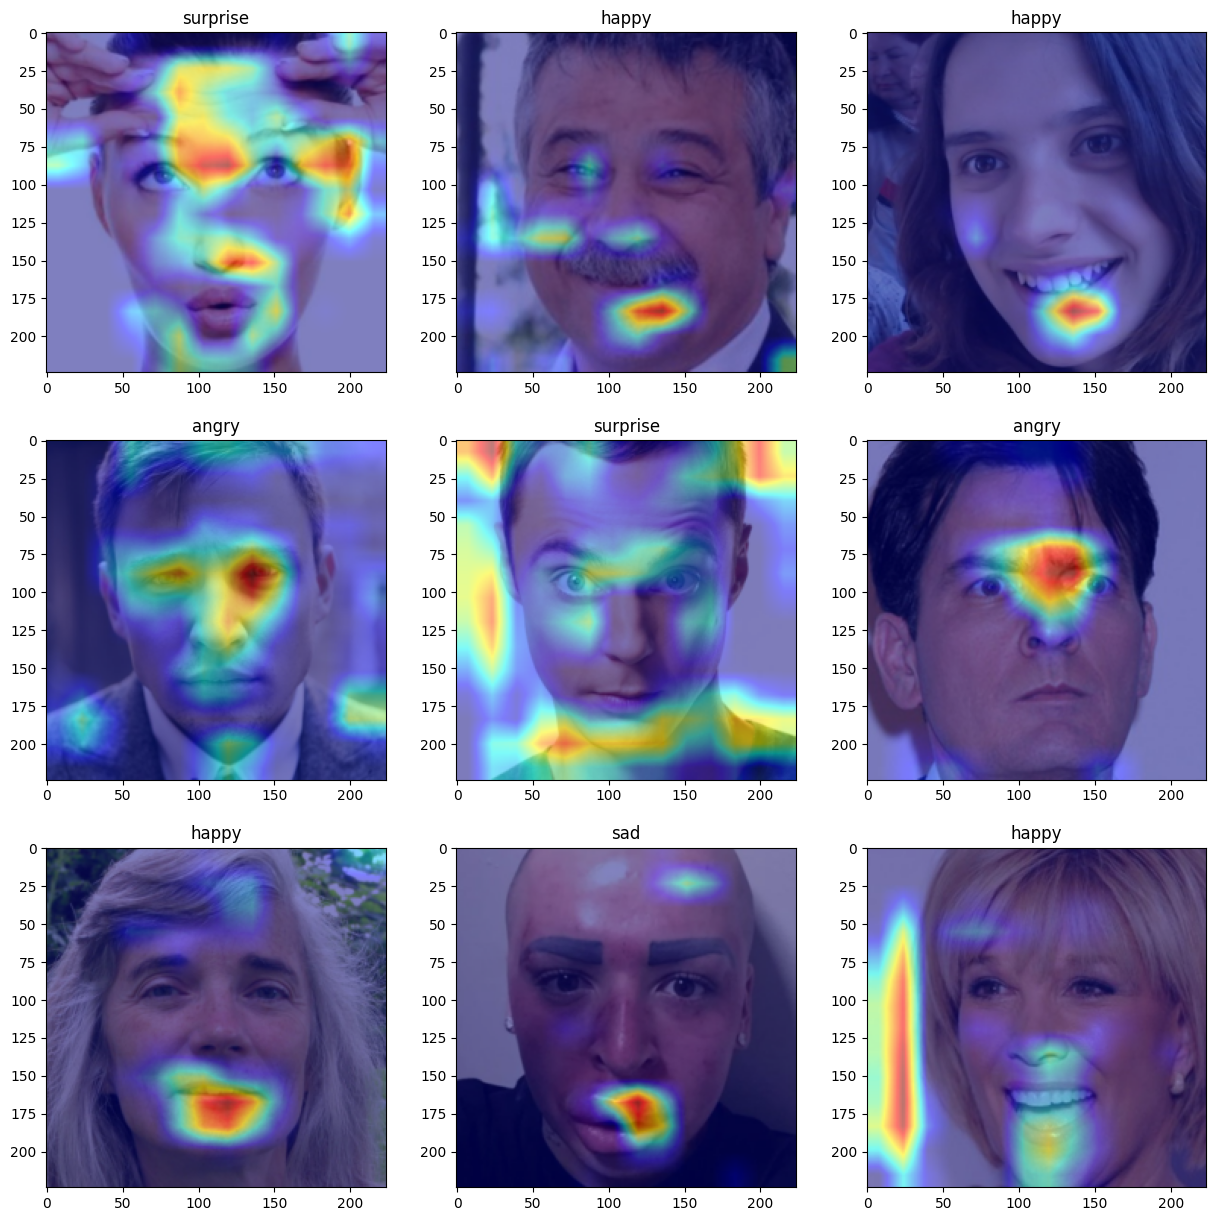

In [6]:
# Select target layer and target class
target_layers = [model.layer3[-1].conv2]
targets = None

# Plot gradcam for nine images
nb_imgs = 9
plt.figure(figsize=(15,15))
for i in range(nb_imgs) :
    plt.subplot(3, 3, i + 1)
    im = imgs[i]
    res1, res2 = compute_gradcam(0, model, im, target_layers, targets)
    emo_label, emo_proba, proba_list = predict.detect_emotion_for_single_face_image(face_image=np.array(im))
    plt.title(emo_label)
    plt.imshow(res2)
plt.show()

## Display activation maps of target layers

conv1 output dimensions : torch.Size([1, 64, 112, 112])


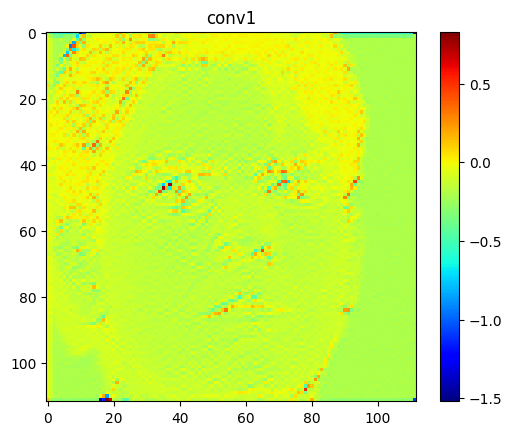

conv2_1 output dimensions : torch.Size([1, 64, 56, 56])


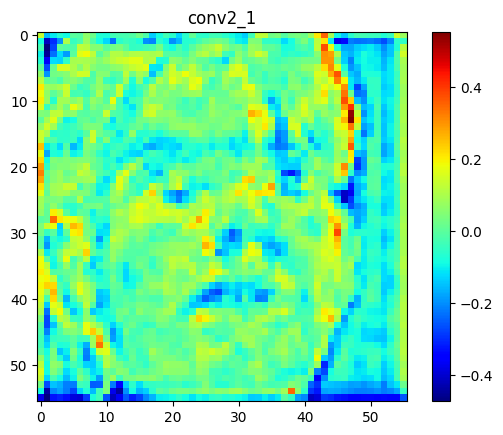

conv2_2 output dimensions : torch.Size([1, 128, 28, 28])


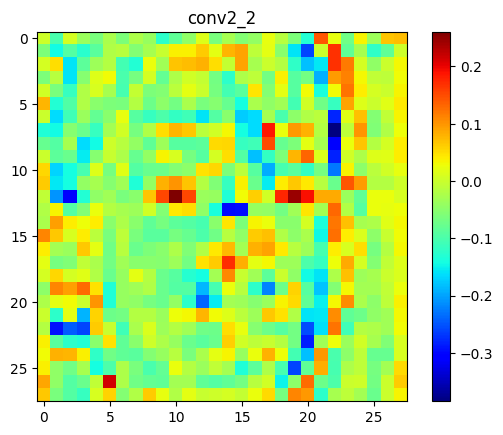

conv2_3 output dimensions : torch.Size([1, 256, 14, 14])


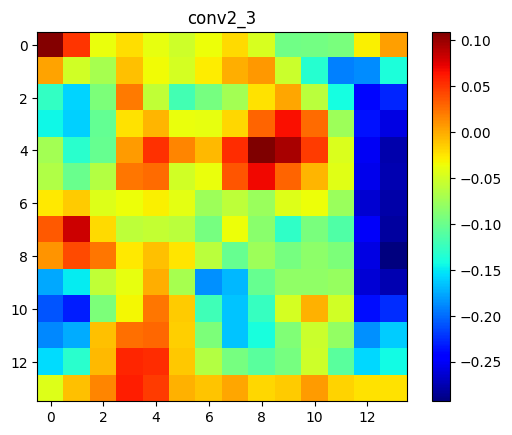

conv2_4 output dimensions : torch.Size([1, 512, 7, 7])


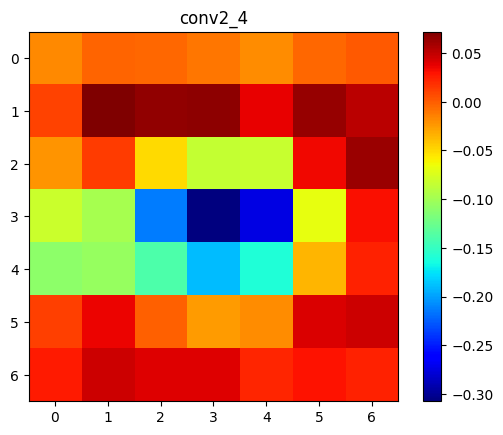

In [7]:
img=imgs[5]

# preprocess input data
transform = transforms.ToTensor()
input_tensor = transform(img.copy()).unsqueeze(0)

# create dictionnary to store activations
activation={}
# define hook to record activations of a given layer
def getActivation(name):
  def hook(model, input, output):
    activation[name] = output.detach()
  return hook

# compute feature maps for several convolution layers
i=0
layers=[model.conv1, model.layer1[-1].conv2, model.layer2[-1].conv2, model.layer3[-1].conv2, model.layer4[-1].conv2]
names=['conv1','conv2_1','conv2_2','conv2_3','conv2_4']
for l in layers :
    name=names[i]
    i+=1
    # attach hook to the layer
    h=l.register_forward_hook(getActivation(name))
    # pass input tensor to gpu then forward input in the model
    output = model(input_tensor.cuda())
    # print output dimensions of layer
    print(name,"output dimensions :",activation[name].shape)
    # pass feature map to cpu then display feature map
    k = 10 # choose feature map number k of the layer
    feature_map = activation[name][0][k].cpu()
    ax = plt.imshow(np.array(feature_map), cmap='jet')
    plt.colorbar(ax)
    plt.title(name)
    plt.show()
    # release hook
    h.remove()